In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
csvPath = "./chicago-west-nile-virus-mosquito-test-results/west-nile-virus-wnv-mosquito-test-results.csv"

In [3]:
## Read Data

df = pd.read_csv(csvPath, encoding="utf-8")
df = df.loc[df['RESULT'] == 'positive']
df.head()

,SEASON YEAR,WEEK,TEST ID,BLOCK,TRAP,TRAP_TYPE,TEST DATE,NUMBER OF MOSQUITOES,RESULT,SPECIES,LATITUDE,LONGITUDE,LOCATION,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
93,2018,38,47646,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,50,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
103,2018,38,47649,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,19,positive,CULEX RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
128,2018,38,47648,25XX W GRAND AVE,T046B,SENTINEL,2018-09-20T00:09:00.000,50,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0
134,2018,38,47637,25XX W GRAND AVE,T046,GRAVID,2018-09-20T00:09:00.000,5,positive,CULEX PIPIENS/RESTUANS,41.892220,-87.691698,"{'longitude': '-87.69169772868295', 'latitude'...",46.0,177.0,21184.0,24.0,41.0
176,2018,37,47562,25XX W GRAND AVE,T046B,SENTINEL,2018-09-13T00:09:00.000,42,positive,CULEX PIPIENS/RESTUANS,41.891455,-87.689763,"{'longitude': '-87.68976265642561', 'latitude'...",46.0,545.0,21184.0,25.0,41.0


In [4]:
df.describe()

,SEASON YEAR,WEEK,TEST ID,NUMBER OF MOSQUITOES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015
count,2338.000000,2338.000000,2338.000000,2338.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000,1748.000000
mean,2013.359281,32.351155,37374.218135,27.734388,41.858417,-87.710915,28.093822,422.210526,19650.413043,40.215103,31.282037
std,3.284551,2.634057,7456.867265,17.377089,0.115472,0.077597,13.820515,249.050932,5667.591178,22.574549,12.667966
min,2007.000000,23.000000,20467.000000,1.000000,41.644720,-87.854473,1.000000,6.000000,4299.000000,4.000000,3.000000
25%,2012.000000,30.000000,33842.750000,12.000000,41.754148,-87.778235,19.000000,177.000000,21202.000000,17.000000,23.000000
50%,2014.000000,32.000000,38825.500000,27.000000,41.891455,-87.723962,29.000000,442.000000,21867.000000,40.000000,34.000000
75%,2016.000000,34.000000,43446.000000,48.000000,41.964405,-87.656762,38.000000,654.000000,22254.000000,62.000000,40.000000
max,2018.000000,39.000000,47649.000000,50.000000,42.013029,-87.531060,50.000000,787.000000,22620.000000,77.000000,53.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338 entries, 93 to 26715
Data columns (total 18 columns):
SEASON YEAR                   2338 non-null int64
WEEK                          2338 non-null int64
TEST ID                       2338 non-null int64
BLOCK                         2338 non-null object
TRAP                          2338 non-null object
TRAP_TYPE                     2338 non-null object
TEST DATE                     2338 non-null object
NUMBER OF MOSQUITOES          2338 non-null int64
RESULT                        2338 non-null object
SPECIES                       2338 non-null object
LATITUDE                      1748 non-null float64
LONGITUDE                     1748 non-null float64
LOCATION                      1748 non-null object
Wards                         1748 non-null float64
Census Tracts                 1748 non-null float64
Zip Codes                     1748 non-null float64
Community Areas               1748 non-null float64
Historical Wards 2003-

In [6]:
## Preprocess data

# df['TEST DATE INT'] = pd.to_datetime(df['TEST DATE']).astype('int64')//1e9
df['TEST DATE INT'] = df['TEST DATE'].str.split('T').str[0].str.replace('-', '').astype('int64')

nonNumCol = ['TRAP', 'BLOCK', 'TRAP_TYPE', 'SPECIES', 'Zip Codes']
for col in nonNumCol:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

df_dropped = df.drop(columns=['LOCATION', 'TEST DATE', 'TEST ID', 'TRAP', 'SEASON YEAR', 'WEEK', 'RESULT'])
df_dropped = df_dropped.dropna()
df_dropped.head()

,BLOCK,TRAP_TYPE,NUMBER OF MOSQUITOES,SPECIES,LATITUDE,LONGITUDE,Wards,Census Tracts,Zip Codes,Community Areas,Historical Wards 2003-2015,TEST DATE INT
93,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
103,42,2,19,2,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
128,42,2,50,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180920
134,42,1,5,1,41.892220,-87.691698,46.0,177.0,9,24.0,41.0,20180920
176,42,2,42,1,41.891455,-87.689763,46.0,545.0,9,25.0,41.0,20180913


In [7]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1748 entries, 93 to 26715
Data columns (total 12 columns):
BLOCK                         1748 non-null int8
TRAP_TYPE                     1748 non-null int8
NUMBER OF MOSQUITOES          1748 non-null int64
SPECIES                       1748 non-null int8
LATITUDE                      1748 non-null float64
LONGITUDE                     1748 non-null float64
Wards                         1748 non-null float64
Census Tracts                 1748 non-null float64
Zip Codes                     1748 non-null int8
Community Areas               1748 non-null float64
Historical Wards 2003-2015    1748 non-null float64
TEST DATE INT                 1748 non-null int64
dtypes: float64(6), int64(2), int8(4)
memory usage: 129.7 KB


In [8]:
X = df_dropped.to_numpy()

In [9]:
neigh = NearestNeighbors(2, 0.4)
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=2, p=2, radius=0.4)

In [10]:
dist, _ = neigh.kneighbors(X)
dist = dist[:,1]
max_dist = max(dist)
min_dist = min(dist)
avg_dist = sum(dist) / len(dist)
med_dist = np.median(dist)

print('Max distance: ', max_dist)
print('Min distance: ', min_dist)
print('Average distance: ', avg_dist)
print('Median distance: ', med_dist)

Max distance:  152.27612164780223
Min distance:  0.0
Average distance:  22.268892584692043
Median distance:  11.045361017187261


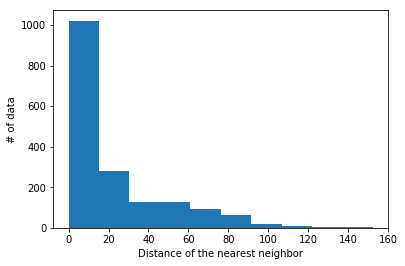

In [11]:
plt.hist(dist)
plt.ylabel('# of data')
plt.xlabel('Distance of the nearest neighbor')
plt.show()

In [12]:
neighbors = neigh.radius_neighbors(X, radius=max_dist, return_distance=False)
neighbors = np.array([len(x) for x in neighbors])

max_neighbors = max(neighbors)
min_neighbors = min(neighbors)
avg_neighbors = sum(neighbors) / len(neighbors)
med_neighbors = np.median(neighbors)
print('Max neighbors: ', max_neighbors)
print('Min neighbors: ', min_neighbors)
print('Average neighbors: ', avg_neighbors)
print('Median neighbors: ', med_neighbors)

Max neighbors:  163
Min neighbors:  2
Average neighbors:  61.50114416475972
Median neighbors:  54.0


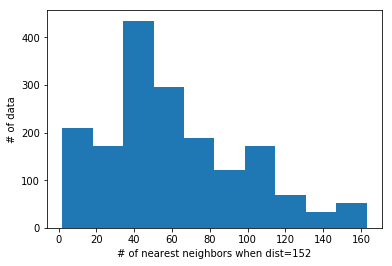

In [13]:
plt.hist(neighbors)
plt.ylabel('# of data')
plt.xlabel('# of nearest neighbors when dist=%d' % max_dist)
plt.show()

In [ ]:
## Draw Silhouette Score

s_scores = []

for i in range(min_neighbors, max_neighbors + 1):
    eps=153
    mins=i

    dbscan = DBSCAN(eps=eps, min_samples=mins)
    labels = dbscan.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    
    s_scores.append(silhouette_avg)

In [ ]:
plt.plot(range(min_neighbors, max_neighbors + 1), s_scores)
plt.ylabel('Silhouette score')
plt.xlabel('# of min samples')
plt.show()

In [ ]:
eps=153
mins=40

In [ ]:
## Clustering

dbscan = DBSCAN(eps=eps, min_samples=mins)
labels = dbscan.fit_predict(X)

label, count = np.unique(labels, return_counts=True)
label_dict = dict(zip(label, count))
print(label_dict)

In [ ]:
## Evaluate

silhouette_avg = silhouette_score(X, labels)
print('The average silhouette_score is : ', silhouette_avg)

In [ ]:
df_dropped['CLUSTERS'] = labels

In [ ]:
## Analysis

for c in label_dict:
    display(df_dropped.loc[df_dropped['CLUSTERS'] == c])